## 差分进化

In [1]:
import numpy as np
import random

### 目标函数

求函数的最小化
$f(x)=\sum_{i=1}^nx_i^2\left(-20\leq x_i\leq20\right)$ 

n=10，x的维度为10，表示为$(x_1,x_2,...,x_{10})$

In [2]:
# 适应度函数/目标函数
def function(x): # x的维度为10，也即D=10
    return sum(x ** 2)
# 求适应度
def fitness(x):
    result=np.empty(x.shape[1]) # 记录种群中个体的适应度
    # 计算每个个体的适应度
    for i in range(0,x.shape[1]):
        result[i]=function(x[:,i])
    return result

### 差分变异
$v_{i,G+1}=x_{r_1,G}+F\cdot(x_{r_2,G}-x_{r_3,G})$

其中$v_i$是突变的结果
i=1,2,3,...,NP
$r_1、r_2、r_3$是随机选择的三个个体的索引
F是突变因子，范围在[0,2]，控制差分的权重

In [3]:
# 差分变异，发生在不同的个体之间
def variation(x,F):
    # 初始化变异个体
    v = np.zeros(x.shape)
    for i in range(0,x.shape[1]):

        # 表示的是在0-NP范围内，随机生成三个整数，作为索引，且保证三个索引不与当前的循环次数i重复（通过这种方式来确保至少有一个个体是变异了的）
        randoms=random.sample(range(0,x.shape[1]),3)# 表示的是在0-x.shape[1]范围内，随机生成三个整数，作为索引
        while randoms[0]==i or randoms[1]==i or randoms[2]==i :
            randoms=random.sample(range(0,x.shape[1]),3)
        # 计算变异的个体
        v[:,i]=x[:,randoms[0]]+(x[:,randoms[1]]-x[:,randoms[2]])*F
    return v

### 交叉
$u_{i,G+1}=(u_{1i,G+1},u_{2i,G+1},\ldots,u_{Di,G+1})$

对于$u_{i,G+1}$

<img src="../imgs/crossover.png" style="zoom:20%;">

CR是交叉因子
$rnbr(i)$是一个范围在[1,2,...,D]的随机数

In [4]:
# 交叉
def cross(x,v,CR):
    u = np.zeros((D, NP))
    rate=np.random.rand()
    for i in range(0,x.shape[0]):
        if rate<=CR or i==rate:
           u[i,:]=v[i,:]
        else:
           u[i,:]=x[i,:]
    return u


### 边界处理（防止溢出）

In [5]:
# 边界处理
def boundary_process(x,left,right):
    for i in range(0,x.shape[0]):
        for j in range(0,x.shape[1]):
            if x[i][j] < left or x[i][j]>right:
                x[i][j]= random.random()*(right - left) + left
    return x

### 参数初始化

In [18]:
NP = 50  # 个体数目
D = 10  # 目标函数中变量的个数
G = 10000  # 最大迭代数
Variation = 0.4  # 变异算子
CR = 0.1  # 交叉算子
Threshold = 1e-6  # 阈值
F=0.5
Left = -20
Right = 20

### 算法的执行

In [22]:
x = np.random.rand(10, 50) * (Right - Left) + Left   #在[Left,Right]之间产生随机数
#记录进化迭代的过程
number_generations=G
per_generation_optimal_value=np.zeros(G)

x_fitness=fitness(x)

for i in range(0,G):
    v=variation(x,F)
    #print("变异后的形状",v.shape)
    c=cross(x,v,CR)
    #print("交叉后的形状",v.shape)
    # 若超出边界则重新生成
    c=boundary_process(c,Left,Right)
    c_fitness=fitness(c)
    # 贪婪地选择当前最优个体
    for m in range(0,x.shape[1]):
        if c_fitness[m]<x_fitness[m]:
            x[:,m]=c[:,m]
            x_fitness[m]=c_fitness[m]
    index=np.argmin(x_fitness)
    per_generation_optimal_value[i]=x_fitness[index]        
                
    print(f"第{i+1}次演化时的最小值的索引为：{index}")
    print(f"最小值为：{x_fitness[index]}")
    print("个体为：",x[:,index])

第1次演化时的最小值的索引为：40
最小值为：467.7920545322286
个体为： [ 0.6096608  12.44986145  0.06979306 -3.55989305  3.42643872  6.40102005
 -6.91332777  0.15981364  6.43815586 12.56027772]
第2次演化时的最小值的索引为：40
最小值为：467.7920545322286
个体为： [ 0.6096608  12.44986145  0.06979306 -3.55989305  3.42643872  6.40102005
 -6.91332777  0.15981364  6.43815586 12.56027772]
第3次演化时的最小值的索引为：40
最小值为：467.7920545322286
个体为： [ 0.6096608  12.44986145  0.06979306 -3.55989305  3.42643872  6.40102005
 -6.91332777  0.15981364  6.43815586 12.56027772]
第4次演化时的最小值的索引为：40
最小值为：467.7920545322286
个体为： [ 0.6096608  12.44986145  0.06979306 -3.55989305  3.42643872  6.40102005
 -6.91332777  0.15981364  6.43815586 12.56027772]
第5次演化时的最小值的索引为：21
最小值为：412.67024034674364
个体为： [-2.82745501  3.2100524  -0.10747138 -0.0812071  -6.94533574  9.88799452
  5.57666982 -7.11007208 12.73461083 -2.12611123]
第6次演化时的最小值的索引为：21
最小值为：412.67024034674364
个体为： [-2.82745501  3.2100524  -0.10747138 -0.0812071  -6.94533574  9.88799452
  5.57666982 -7.11007208 12.734610

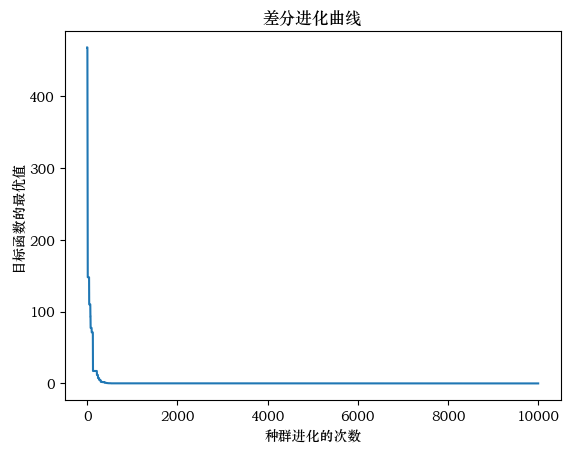

In [25]:
import matplotlib.pyplot as plt
# 设置可显示中文宋体
plt.rcParams['font.family'] = 'STZhongsong'
# 生成 x 轴数据：0 到 10000，间隔为 1
x = np.arange(0, number_generations, 1)

# 生成 y 轴数据：0 到 1 的随机值，长度与 x 轴一致
y = per_generation_optimal_value

# 绘制折线图
plt.plot(x, y)

# 设置标题和坐标轴标签
plt.title("差分进化曲线")
plt.xlabel("种群进化的次数")
plt.ylabel("目标函数的最优值")

# 显示图形
plt.show()
